<a href="https://colab.research.google.com/github/DenisPotekhin2002/Generative-Models-2025/blob/main/Assignment%202/2_gan_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2025, MSc course**


## Assignment 2

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [2]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542488, -0.60313725, -0.47084969,
        -0.33856213, -0.20627451, -0.07398695,  0.05830061,  0.19058824,
         0.32287574,  0.45516336,  0.58745098,  0.71973848,  0.8520261 ,
         0.98431373]),
 <BarContainer object of 15 artists>)

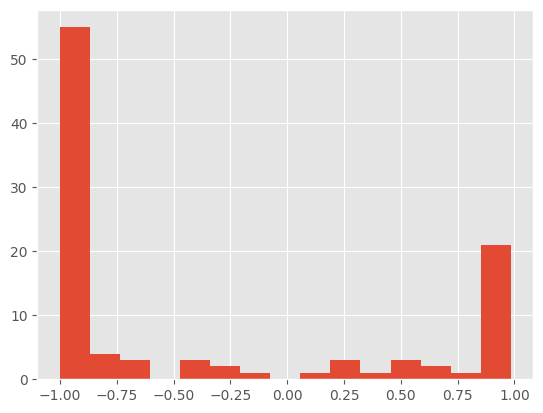

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Original MNIST image:


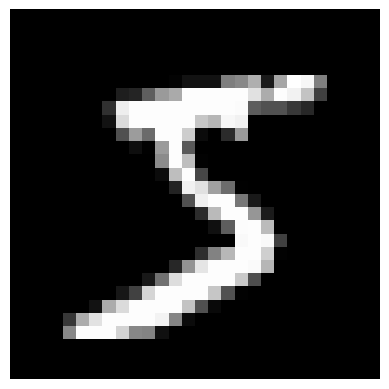

In [5]:
import torchvision

# show image sample with matplotlib
def show_image(img_tensor, denormalize=True):
    """
    Display a single image tensor.

    Args:
        img_tensor: Tensor of shape (1, 28, 28) or (28, 28)
        denormalize: Whether to denormalize from [-1,1] to [0,1]
    """
    if denormalize:
        img_tensor = denorm(img_tensor)

    # Convert to numpy and squeeze channel dimension if needed
    if img_tensor.dim() == 3 and img_tensor.size(0) == 1:
        img_np = img_tensor.squeeze(0).numpy()
    else:
        img_np = img_tensor.numpy()

    plt.imshow(img_np, cmap='gray')
    plt.axis('off')
    plt.show()

# Example usage with the image we loaded earlier
print("Original MNIST image:")
show_image(img)

# Also useful: function to show multiple images in a grid
def show_images_grid(images, nrow=8, denormalize=True):
    """
    Display multiple images in a grid.

    Args:
        images: Tensor of shape (N, 1, 28, 28)
        nrow: Number of images per row
        denormalize: Whether to denormalize from [-1,1] to [0,1]
    """
    if denormalize:
        images = denorm(images)

    # Create grid
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)

    # Convert to numpy and change order for matplotlib
    grid_np = grid.numpy().transpose((1, 2, 0))

    # If grayscale, squeeze the channel dimension
    if grid_np.shape[2] == 1:
        grid_np = grid_np.squeeze(2)
        plt.imshow(grid_np, cmap='gray')
    else:
        plt.imshow(grid_np)

    plt.axis('off')
    plt.show()

In [6]:
# define the dataloader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        # set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        # set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)

        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

### Create the Generator and Discriminator

In [8]:
# create new Generator model
G = Generator(latent_size, image_size, hidden_size).to(device)

# create new Discriminator model
D = Discriminator(image_size, hidden_size).to(device)

In [9]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))

In [10]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()

# Define the optimizer for generator and discriminator
g_optimizer = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

Discriminator Training

In [11]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(D_model, G_model, images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D_model(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images.detach())  # detach to avoid training G on these labels
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Sum losses
    d_loss = d_loss_real + d_loss_fake

    # Reset gradients
    reset_grad()

    # Compute gradients
    d_loss.backward()

    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [12]:
def train_generator(G_model):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)

    # calculate the generator loss
    g_outputs = D(fake_images)
    g_loss = criterion(g_outputs, labels)

    # Reset gradients
    reset_grad()

    # Backprop and optimize
    g_loss.backward()
    g_optimizer.step()

    return g_loss, fake_images

### Start the training proccess

In [13]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [14]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)

        # Train the generator
        g_loss, fake_images = train_generator(G)

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch + 1,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # Sample and save images at the end of each epoch
    save_fake_images_mnist(G, epoch + 1)

Epoch [1/300], Step [200/600], d_loss: 1.0213, g_loss: 1.3319, D(x): 0.80, D(G(z)): 0.55
Epoch [1/300], Step [400/600], d_loss: 0.1120, g_loss: 2.3329, D(x): 1.00, D(G(z)): 0.11
Epoch [1/300], Step [600/600], d_loss: 0.3457, g_loss: 2.6566, D(x): 0.86, D(G(z)): 0.16
Saving fake_images-0001.png
Epoch [2/300], Step [200/600], d_loss: 0.5899, g_loss: 2.8818, D(x): 0.83, D(G(z)): 0.29
Epoch [2/300], Step [400/600], d_loss: 0.3754, g_loss: 2.6507, D(x): 0.86, D(G(z)): 0.16
Epoch [2/300], Step [600/600], d_loss: 0.4447, g_loss: 2.0914, D(x): 0.77, D(G(z)): 0.07
Saving fake_images-0002.png
Epoch [3/300], Step [200/600], d_loss: 0.3970, g_loss: 2.0455, D(x): 0.84, D(G(z)): 0.14
Epoch [3/300], Step [400/600], d_loss: 0.3188, g_loss: 2.5727, D(x): 0.84, D(G(z)): 0.07
Epoch [3/300], Step [600/600], d_loss: 0.2761, g_loss: 3.2682, D(x): 0.90, D(G(z)): 0.12
Saving fake_images-0003.png
Epoch [4/300], Step [200/600], d_loss: 0.1881, g_loss: 3.3821, D(x): 0.92, D(G(z)): 0.06
Epoch [4/300], Step [400/6

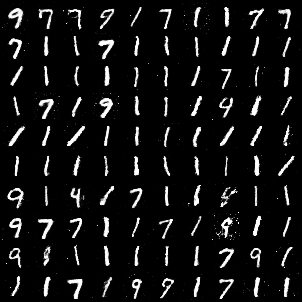

In [17]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0225.png"))

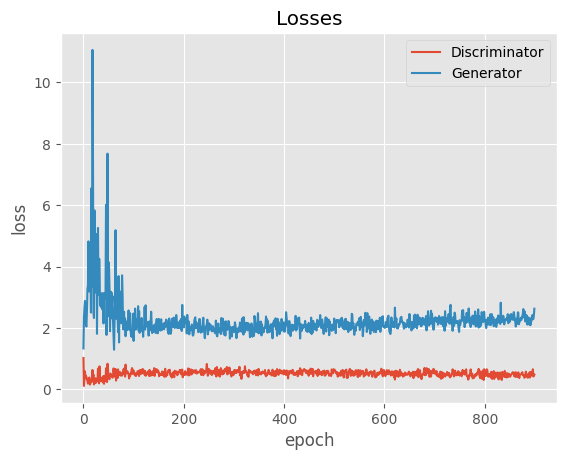

In [18]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

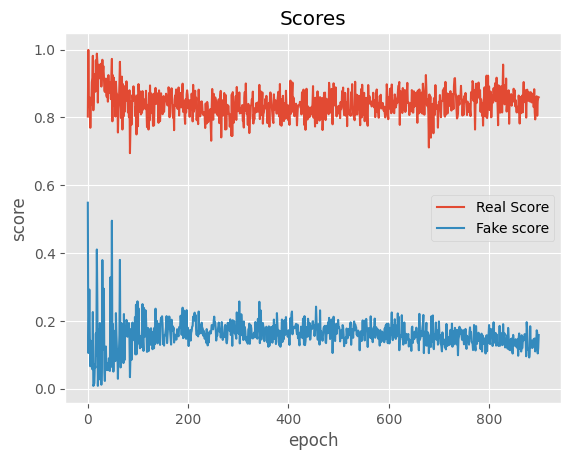

In [19]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [20]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124187, -0.74797386, -0.68470585, -0.62143791,
        -0.55816996, -0.49490196, -0.43163398, -0.368366  , -0.30509806,
        -0.24183005, -0.17856205, -0.1152941 , -0.05202615,  0.01124185,
         0.07450986]),
 <BarContainer object of 15 artists>)

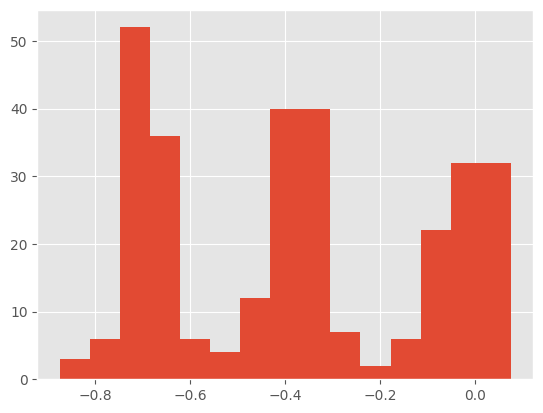

In [21]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

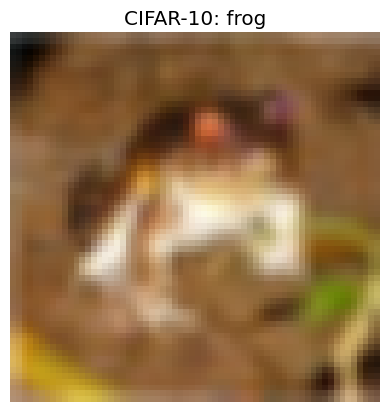

In [22]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    # write your code
    out = (img + 1) / 2
    return out.clamp(0, 1)

# show image sample with matplotlib
def show_image(img_tensor, denormalize=True, title=None):
    """
    Display a single image tensor.

    Args:
        img_tensor: Tensor of shape (3, 64, 64) for CIFAR-10
        denormalize: Whether to denormalize from [-1,1] to [0,1]
        title: Optional title for the plot
    """
    if denormalize:
        img_tensor = denorm(img_tensor)

    # Convert to numpy and change dimension order for matplotlib
    img_np = img_tensor.numpy().transpose((1, 2, 0))

    plt.imshow(img_np)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

show_image(img, title=f"CIFAR-10: {cifar_dataset.classes[label]}")

In [23]:
# create the dataloader
cifar_dataloader = torch.utils.data.DataLoader(
    cifar_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    num_workers=CFG.workers,
    pin_memory=True if CFG.device == "cuda" else False
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### DCGAN implementation

In [24]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ngf*4) x 8 x 8

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ngf*2) x 16 x 16

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: (ngf) x 32 x 32

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )

    def forward(self, x):
        return self.main(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size: 1 x 1 x 1
        )

    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [25]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)

# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf).to(CFG.device)

In [27]:
# show the output of model
# y = DCG(torch.randn(2, CFG.nz))
y = DCG(torch.randn(2, CFG.nz, 1, 1).to(CFG.device))

In [29]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
CFG.beta1 = 0.5
optimizerG = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))
optimizerD = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))

In [30]:
# feel free to reuse your training functions

### Start the training proccess

In [31]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images_cifar-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [34]:
%%time
device = CFG.device
num_epochs = CFG.num_epochs
batch_size = CFG.batch_size

# Define necessary functions
def reset_grad():
    optimizerD.zero_grad()
    optimizerG.zero_grad()

def train_dcgan_discriminator(real_images):
    batch_size = real_images.size(0)
    real_labels = torch.full((batch_size,), 1.0, device=device)
    fake_labels = torch.full((batch_size,), 0.0, device=device)

    # Train with real images
    outputs = DCD(real_images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Train with fake images
    z = torch.randn(batch_size, CFG.nz, 1, 1, device=device)
    fake_images = DCG(z)
    outputs = DCD(fake_images.detach())
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    optimizerD.step()

    return d_loss, real_score, fake_score

def train_dcgan_generator():
    batch_size = CFG.batch_size
    z = torch.randn(batch_size, CFG.nz, 1, 1, device=device)
    fake_images = DCG(z)
    labels = torch.full((batch_size,), 1.0, device=device)

    outputs = DCD(fake_images)
    g_loss = criterion(outputs, labels)
    reset_grad()
    g_loss.backward()
    optimizerG.step()

    return g_loss, fake_images

def denorm(x):
    return (x + 1) / 2

def save_fake_images_cifar(index):
    sample_vectors = torch.randn(batch_size, CFG.nz, 1, 1).to(device)
    fake_images = DCG(sample_vectors)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10)

# Initialize optimizers and criterion
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(DCG.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))
optimizerD = torch.optim.Adam(DCD.parameters(), lr=CFG.lr, betas=(CFG.beta1, 0.999))

# Fix: Use cifar_dataloader instead of data_loader
total_step = len(cifar_dataloader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(device)
DCD.to(device)

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(cifar_dataloader):  # Fix: Use cifar_dataloader
        # Load a batch - DON'T reshape for DCGAN (keep as 4D tensor)
        images = images.to(device)  # Fix: Remove the reshape line

        # Train the discriminator
        d_loss, real_score, fake_score = train_dcgan_discriminator(images)

        # Train the generator
        g_loss, _ = train_dcgan_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(epoch + 1)

Epoch [0/300], Step [200/391], d_loss: 0.2634, g_loss: 2.5988, D(x): 0.89, D(G(z)): 0.13
Saving fake_images-0001.png
Epoch [1/300], Step [200/391], d_loss: 0.3557, g_loss: 2.5582, D(x): 0.87, D(G(z)): 0.17
Saving fake_images-0002.png
Epoch [2/300], Step [200/391], d_loss: 2.7320, g_loss: 9.2193, D(x): 1.00, D(G(z)): 0.91
Saving fake_images-0003.png
Epoch [3/300], Step [200/391], d_loss: 1.1622, g_loss: 1.7649, D(x): 0.40, D(G(z)): 0.05
Saving fake_images-0004.png


KeyboardInterrupt: 

In [ ]:
# show your results!
print("Training completed!")

# Plot the results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.title('Training Losses')
plt.xlabel('Iterations (every 200 steps)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(real_scores, label='Real Score')
plt.plot(fake_scores, label='Fake Score')
plt.title('Discriminator Scores')
plt.xlabel('Iterations (every 200 steps)')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
# Calculate accuracy
accuracy = [(1 if r > 0.5 else 0) + (1 if f < 0.5 else 0) for r, f in zip(real_scores, fake_scores)]
accuracy = [a / 2 for a in accuracy]
plt.plot(accuracy)
plt.title('Discriminator Accuracy')
plt.xlabel('Iterations (every 200 steps)')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the final models
torch.save(DCG.state_dict(), 'dcgan_generator_final.pth')
torch.save(DCD.state_dict(), 'dcgan_discriminator_final.pth')
print("Final models saved!")